In [1]:
!pip install librosa matplotlib tensorflow soundfile


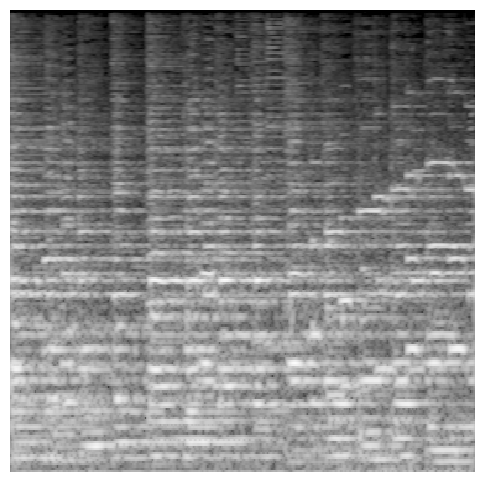

<class 'numpy.ndarray'>


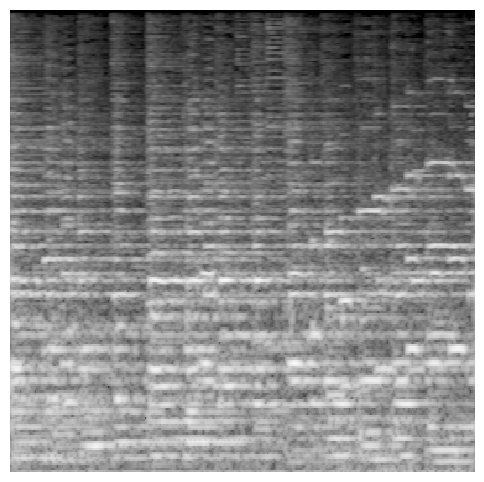

In [9]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from PIL import Image
from io import BytesIO

# 参数设置
x_res = 375
y_res = 375
sample_rate = 24000
n_fft = 2048
hop_length = 256
n_mels = 256
n_iter = 50
top_db = 80

# 加载音频文件
audio_path = '/content/ApgCxwAImCE_test_slide0.wav'
y, sr = librosa.load(audio_path, sr=sample_rate)

# 生成 Mel 频谱图
S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
S_db = librosa.power_to_db(S, ref=np.max)

# 显示 Mel 频谱图
plt.figure(figsize=(6, 6))
librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='gray')
plt.axis('off')  # 关闭坐标轴
plt.show()

# 将 Mel 频谱图转换为图像
def mel_spectrogram_to_image(S_db, top_db):
    """Converts a Mel spectrogram to a PIL Image."""
    S_db = np.clip(S_db, a_min=None, a_max=top_db)
    S_db_normalized = (S_db - S_db.min()) / (S_db.max() - S_db.min()) * 255
    S_db_image = Image.fromarray(S_db_normalized.astype(np.uint8))
    return S_db_image

# 从图像中恢复 Mel 频谱图
def image_to_mel_spectrogram(image: Image.Image, top_db) -> np.ndarray:
    """Converts a PIL Image back to a Mel spectrogram."""
    bytedata = np.frombuffer(image.tobytes(), dtype="uint8").reshape((image.height, image.width))
    log_S = bytedata.astype("float") * top_db / 255 - top_db
    S = librosa.db_to_power(log_S)
    return S

# 从 Mel 频谱图图像恢复音频
def mel_spectrogram_to_audio(S, sr, n_fft, hop_length, n_iter) -> np.ndarray:
    """Converts a Mel spectrogram to audio using Griffin-Lim."""
    audio = librosa.feature.inverse.mel_to_audio(
        S, sr=sr, n_fft=n_fft, hop_length=hop_length, n_iter=n_iter
    )
    return audio

# 转换 Mel 频谱图为图像
mel_image = mel_spectrogram_to_image(S_db, top_db)

# 从图像恢复 Mel 频谱图
S_reconstructed = image_to_mel_spectrogram(mel_image, top_db)
print(type(S_reconstructed))
S_db_r = librosa.power_to_db(S_reconstructed, ref=np.max)

# 显示 Mel 频谱图
plt.figure(figsize=(6, 6))
librosa.display.specshow(S_db_r, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='gray')
plt.axis('off')  # 关闭坐标轴
plt.show()


# 使用 Griffin-Lim 算法从 Mel 频谱图还原音频
y_reconstructed = mel_spectrogram_to_audio(S_reconstructed, sr, n_fft, hop_length, n_iter)

# 确保重建的音频长度与原音频长度一致
y_reconstructed = librosa.util.fix_length(y_reconstructed, size=len(y))

# 保存重建的音频文件
output_path = '/content/reconstructed_mel_from_image.wav'
sf.write(output_path, y_reconstructed, sr)

# 播放音频
from IPython.display import Audio
Audio(output_path)
